In [2]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import glob
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import time
from scipy import interpolate
import seaborn as sns

from ipywidgets import IntProgress
from IPython.display import display

In [3]:
#Set latex environment for plots/labels
# matplotlib.rc('font', **{'family': 'serif'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams.update({'font.family':'serif'})


fl=22
fm=18
fs=16

# sns.set_style("white")

<ipython-input-3-ccf62a98d5bf>:4: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']


In [4]:
from natal_kick_tools import mandel_muller_likelihood_functions as mmf
from natal_kick_tools import likelihood_plot_functions as lpf

In [5]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = fm, second=False, labelpad=None, setMinor=True):
    plt.rcParams.update({'font.family':'serif'})

    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [6]:
# Define the models of interest
bh_kicks=[200]
ns_kicks = [300, 350, 400, 450, 500, 550, 600, 650, 700]
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]

# Define the location of the posterior data
pulsar_data_loc = "../correctedPulsarPosteriors/correctedVtData"

# Read Velocity Data

## Model Velocities

In [7]:
# Define a dictionary to map v_ns and sigma to their arrays
kick_models = {}
sig = len(sigmas)
vns = len(ns_kicks)

for i in range(len(ns_kicks)):
    kick_models[f"NS_{ns_kicks[i]}_RANGE"] = np.arange(i*sig, (i*sig)+sig, 1)

for i in range(len(sigmas)):
    kick_models[f"SIGMA_{sigmas[i]}_RANGE"] = np.arange(i, (vns*sig) + i, sig)

kick_models["ALL"] = np.arange(0, vns*sig, 1)

In [8]:
# Read model velocity data (takes ~2 min)

start = time.time()

NS_KICKS_3D = []
NS_KICKS_2D = []
NS_KICK_MULT = [] 
SIGMAS = []

f = IntProgress(min=0, max=sig*vns) # instantiate the bar
display(f) # display the bar

for ns_kick in ns_kicks:
    for sigma in sigmas:
        f.value +=1
        fname = f"model_velocities/vns_{ns_kick}_sigma_{sigma}_velocities"
        v_3d, v_2d = np.loadtxt(fname, skiprows=1, unpack=True)
        NS_KICKS_3D.append(v_3d)
        NS_KICKS_2D.append(v_2d)
        NS_KICK_MULT.append(ns_kick)
        SIGMAS.append(sigma)    
        
end = time.time()
print(end - start, "s")

IntProgress(value=0, max=45)

67.28544497489929 s


In [33]:
def plot_kde(PLOT_RANGE, d=3, output=None):

    for i in PLOT_RANGE:
        kde_NS_3D = gaussian_kde( NS_KICKS_3D[i] )
        kde_NS_2D = gaussian_kde( NS_KICKS_2D[i] )
        NS_dist_space = linspace( min(NS_KICKS_3D[i]), max(NS_KICKS_3D[i]), 100 )
        label_str = r'$v_{ns}$=' + '{nskick}'.format(nskick=NS_KICK_MULT[i]) + ', $\sigma_{ns}$=' + '{sig}'.format(sig=SIGMAS[i])
        if d==2:
            plt.plot( NS_dist_space, kde_NS_2D(NS_dist_space), label=label_str);
        else:
            plt.plot( NS_dist_space, kde_NS_3D(NS_dist_space), label=label_str);

    layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
               nameY='Kick Velocity prob dist [(km/s)$^{-1}$]')

    plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0), useMathText=True)

    # plt.ylim(0, 5e-3)
    plt.xlim(0, 1200)

    plt.legend(fontsize=fs)
    plt.tight_layout()
    if output is not None:
        plt.savefig(output)
        
#     plt.show()

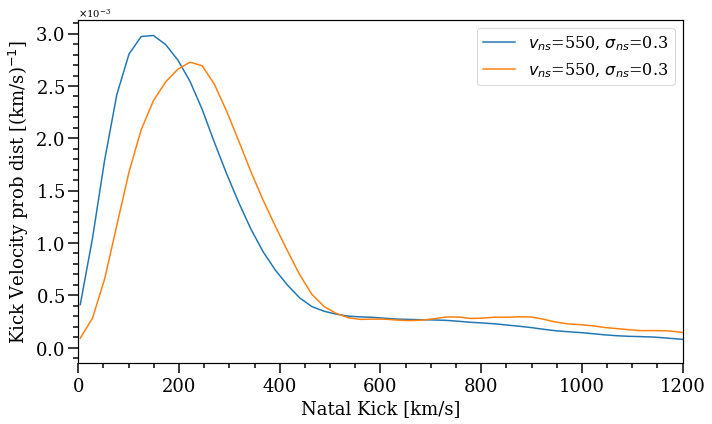

In [34]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
plt.rcParams.update({'font.family':'serif'})
plot_kde(np.intersect1d(kick_models["NS_550_RANGE"], kick_models["SIGMA_0.3_RANGE"]), d=2)
plot_kde(np.intersect1d(kick_models["NS_550_RANGE"], kick_models["SIGMA_0.3_RANGE"]), d=3)
plt.show()

## Paper plots

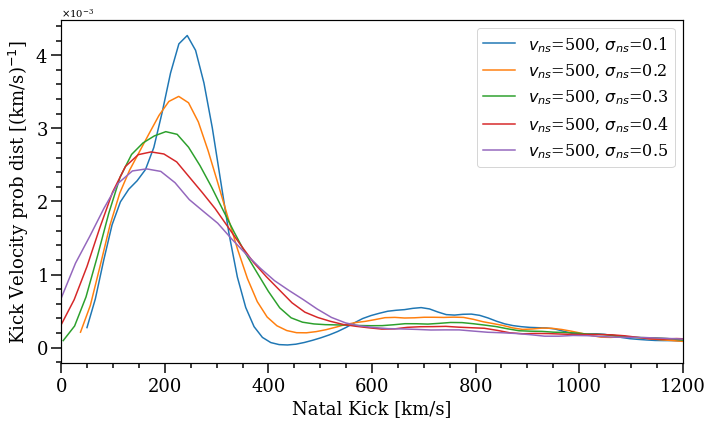

In [35]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
plot_kde(kick_models["NS_500_RANGE"], output='plots/ns_kicks_500_range.pdf')

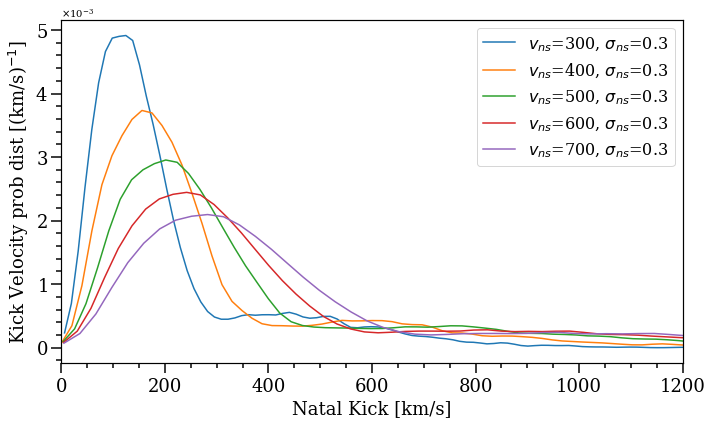

In [36]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
plot_kde(kick_models["SIGMA_0.3_RANGE"][::2], output='plots/sigma_0.3_range.pdf')

# Read Likelihood Data

In [37]:
p_models = []
columns = [] # labels for plotting model likelihoods in next cell
for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"calculatedModelLikelihoods/vns_{ns_kick}_sigma_{sigma}"
        all_likelihoods = np.loadtxt(fname)
        p_models.append(np.prod(all_likelihoods))
        
        col_name = f"vns_{ns_kick}_sigma_{sigma}"
        columns.append(col_name)
        
# normalize the array
p_models = p_models/np.max(p_models)


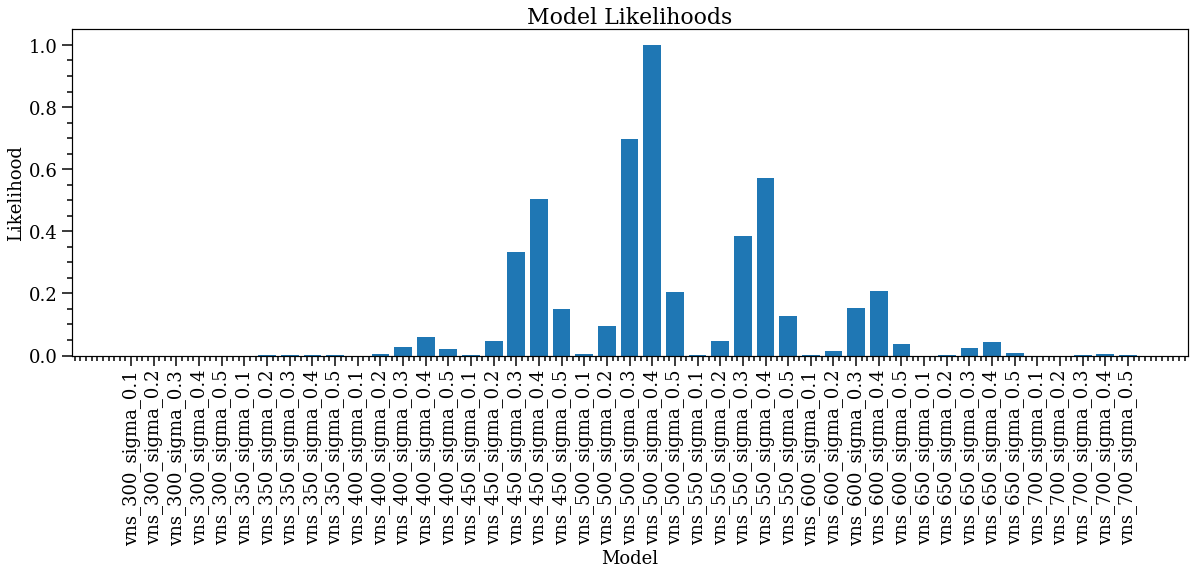

In [38]:
f, ax= plt.subplots(1, 1,  figsize=(20,6)) 

x_range = np.linspace(0, len(p_models), len(p_models))
plt.bar(x_range, p_models, tick_label=columns)

layoutAxes(ax=ax, nameX='Model',\
           nameY='Likelihood')
plt.xticks(rotation=90)
# plt.semilogy()

plt.title("Model Likelihoods", fontsize=fl)

plt.show()

## 2D Plot

In [39]:
p_models_2d = p_models.reshape([len(ns_kicks), len(sigmas)])
max_num = len(p_models) # number of max likelihoods to label

# Some code to generate labels for only the top n models
M = sorted(zip(p_models), reverse=True)[max_num - 1][0]
label_f  = np.vectorize(lambda v: f"{v:.3f}" if v >= M else '')
labels = label_f(p_models_2d)

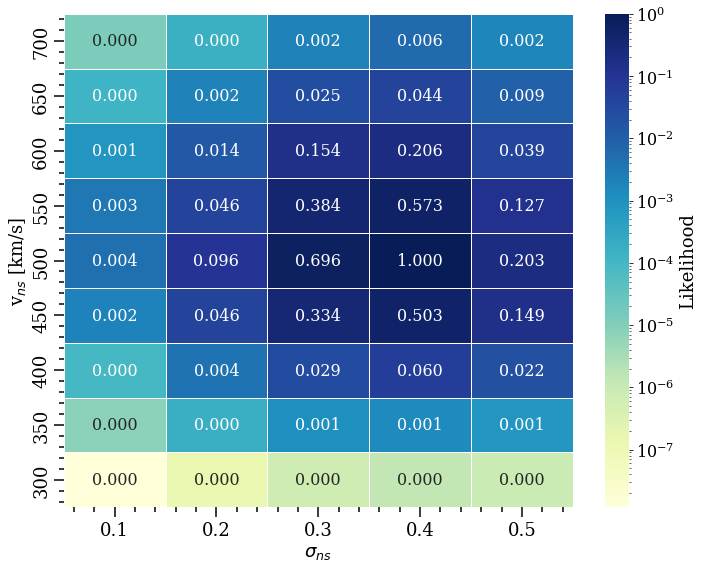

In [40]:
f, ax= plt.subplots(1, 1,  figsize=(10,8)) 

ax = sns.heatmap(p_models_2d, cmap="YlGnBu", linewidth=0.5, norm=LogNorm(), xticklabels=sigmas, yticklabels=ns_kicks, \
                annot=labels, annot_kws={'fontsize':fs}, fmt='', cbar_kws={'label': 'Likelihood'})
layoutAxes(ax=ax, fontsize=18)

plt.xlabel('$\sigma_{ns}$', fontsize=fm)
plt.ylabel('v$_{ns}$ [km/s]', fontsize=fm)

ax.figure.axes[-1].yaxis.label.set_size(fm)
ax.figure.axes[-1].tick_params(labelsize=fs)


plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig('plots/model_likelihoods_2d.pdf')  
plt.show()


## 1 sigma, 2 sigma plot

In [41]:
one_sig = 0.6827/2
two_sig = 0.9545/2

In [42]:
M = 0
label_f  = np.vectorize(lambda v: f"{v:.3f}" if v >= M else '')
labels_all = label_f(p_models_2d)

M = np.max(p_models) - one_sig
label_f  = np.vectorize(lambda v: f"{v:.3f}" if v >= M else '')
labels_one_sig = label_f(p_models_2d)
# labels_one_sig

M = np.max(p_models) - two_sig
label_f  = np.vectorize(lambda v: f"{v:.3f}" if (v >= M and v <= 0.69) else '')
labels_two_sig = label_f(p_models_2d)
# labels_two_sig

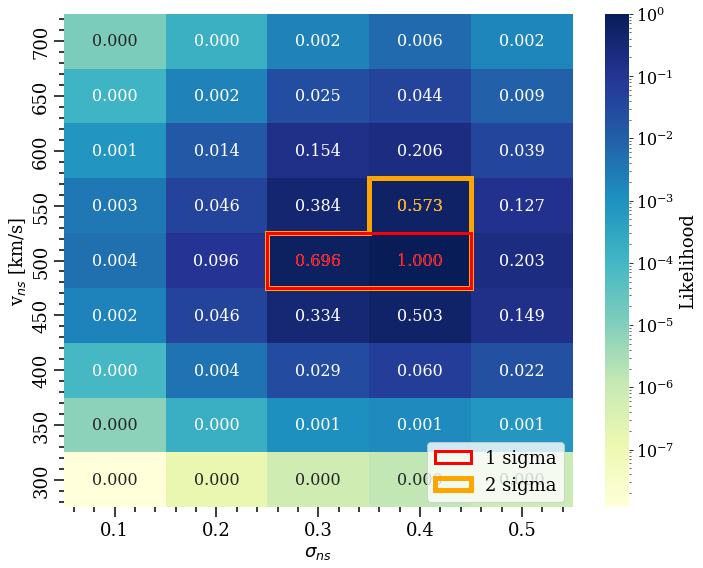

In [55]:
from matplotlib.patches import Rectangle, Polygon

f, ax= plt.subplots(1, 1,  figsize=(10,8)) 

ax = sns.heatmap(p_models_2d,  cmap="YlGnBu", linewidth=0, norm=LogNorm(),\
                 annot=labels_all, annot_kws={'fontsize':fs}, fmt="", cbar=False)

ax = sns.heatmap(p_models_2d,  cmap="YlGnBu", linewidth=0., norm=LogNorm(),\
                 annot=labels_two_sig, annot_kws={'fontsize':fs, 'color':"orange"}, fmt="", cbar=False)

ax = sns.heatmap(p_models_2d, cmap="YlGnBu", linewidth=0., norm=LogNorm(), xticklabels=sigmas, yticklabels=ns_kicks, \
                annot=labels_one_sig, annot_kws={'fontsize':fs, 'color':"r"}, fmt='', cbar_kws={'label': 'Likelihood'})



ax.add_patch(Polygon(((2, 4), (2, 5), (3, 5), (3, 6), (4, 6), (4, 4)), fill=False, edgecolor='orange', hatch='', lw=5, clip_on=False, label='2 sigma'))
ax.add_patch(Rectangle((2, 4), 2, 1, fill=False, edgecolor='r', hatch='',  lw=3, clip_on=False, label= '1 sigma'))



layoutAxes(ax=ax, fontsize=18)

plt.xlabel('$\sigma_{ns}$', fontsize=fm)
plt.ylabel('v$_{ns}$ [km/s]', fontsize=fm)

ax.figure.axes[-1].yaxis.label.set_size(fm)
ax.figure.axes[-1].tick_params(labelsize=fs)

handles, labels = plt.gca().get_legend_handles_labels()
  
# specify order
order = [1,0]
  
# pass handle & labels lists along with order as below
plt.legend([handles[i] for i in order], [labels[i] for i in order], bbox_to_anchor=(1.0, 0.15), fontsize=fm)

# leg = ax.legend()

# for line in leg.get_lines():
#     line.set_linewidth(1.0)

plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig('plots/model_likelihoods_2d.pdf')  
plt.show()


In [17]:
# Identify the 3 most likely models
M = sorted(zip(p_models), reverse=True)[:3]
MAX_INDICES = np.where(p_models==M)[1]

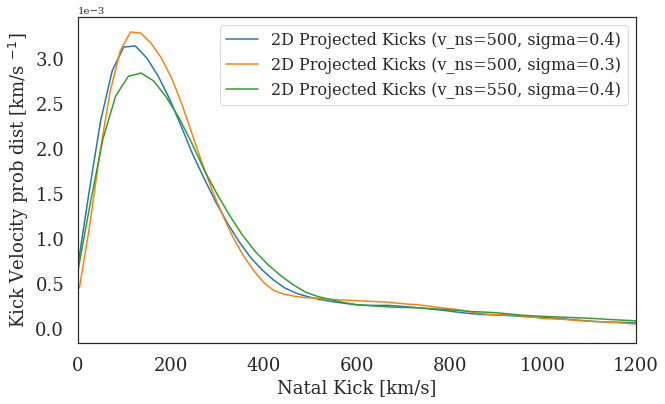

In [29]:
# The three most likely models
f, ax= plt.subplots(1, 1,  figsize=(10,6))
plot_kde(MAX_INDICES, d=2)
plt.show()